In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, count, avg, sum, when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf, col, log
from pyspark.sql.types import FloatType

pd.set_option('display.float_format', '{:.0f}'.format)

In [2]:
spark = SparkSession.builder.appName("temp1").getOrCreate()
spark

# Data cleaning

In [3]:
# Import libraries
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder.appName("read_tsv").getOrCreate()

# Read tsv file
data1 = spark.read.option("delimiter", "\t").csv("gs://msca-bdp-student-gcs/group10-amazon-review/amazon_reviews_us_Baby_v1_00.tsv", header=True, inferSchema=True)
data2 = spark.read.option("delimiter", "\t").csv("gs://msca-bdp-student-gcs/group10-amazon-review/amazon_reviews_us_Beauty_v1_00.tsv", header=True, inferSchema=True)
data3 = spark.read.option("delimiter", "\t").csv("gs://msca-bdp-student-gcs/group10-amazon-review/amazon_reviews_us_Camera_v1_00.tsv", header=True, inferSchema=True)
data4 = spark.read.option("delimiter", "\t").csv("gs://msca-bdp-student-gcs/group10-amazon-review/amazon_reviews_us_Electronics_v1_00.tsv", header=True, inferSchema=True)
data5 = spark.read.option("delimiter", "\t").csv("gs://msca-bdp-student-gcs/group10-amazon-review/amazon_reviews_us_Furniture_v1_00.tsv", header=True, inferSchema=True)

In [4]:
# Using union to combine the DataFrames
data = data1.union(data2).union(data3).union(data4).union(data5)

In [5]:
#show dataframe 
data.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|    9970739| R8EWA1OFT84NX|B00GSP5D94|     329991347|Summer Infant Swa...|            Baby|          5|            0|          0|   N|                Y|Great swaddled bl...|Loved these swadd...| 2015-08-31|
|         US|   23538442|R2JWY4YRQD4FOP|B00YYDDZGU|     646108902|Pacifier Clip Gir...|            Baby|          5|    

In [6]:
#data cleaning

from pyspark.sql.functions import col

#check any NA values
missing_count = [data.filter(col(customer_id).isNull()).count() for customer_id in data.columns]
missing_values = dict(zip(data.columns, missing_count))

# missing value counts
for column, count in missing_values.items():
    print(f"Missing values in '{column}': {count}")
    

#remove missing values
data_1 = data.dropna()

# Check for duplicates based on a column

data_dup = data_1.dropDuplicates(subset=["review_body", "review_id"])
# Count rows and see if duplicate rows were removed
data_dup.count()

from pyspark.sql.functions import length
data_text = data_dup.filter(length(data_dup["review_body"]) > 5)

# Count rows
data_text.count()


# convert to all lowercase text for consistency

from pyspark.sql.functions import lower
 
cols_lower = ["review_body", "product_title", "product_category","review_headline"]

# Apply lowercase conversion to each column
for col in cols_lower:
    data_text = data_text.withColumn(col, lower(data_text[col]))
    
    
#remove any unwanted characters

from pyspark.sql.functions import regexp_replace

cols_lower = ["review_body", "product_title", "product_category","review_headline"]

# Pattern for text cleaning
pattern = "[^a-zA-Z0-9\\s]"

# Apply text cleaning pattern to each column
for col in cols_lower:
    data_text = data_text.withColumn(col, regexp_replace(data_text[col], pattern, ""))


Missing values in 'marketplace': 0
Missing values in 'customer_id': 0
Missing values in 'review_id': 0
Missing values in 'product_id': 0
Missing values in 'product_parent': 0
Missing values in 'product_title': 0
Missing values in 'product_category': 223
Missing values in 'star_rating': 223
Missing values in 'helpful_votes': 224
Missing values in 'total_votes': 224
Missing values in 'vine': 224
Missing values in 'verified_purchase': 224
Missing values in 'review_headline': 237
Missing values in 'review_body': 1579
Missing values in 'review_date': 836


# EDA

In [7]:
sampled_df = data_text.sample(False, 0.05)

df_pd = sampled_df.toPandas()

23/11/27 21:40:17 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
data_text.dtypes

[('marketplace', 'string'),
 ('customer_id', 'int'),
 ('review_id', 'string'),
 ('product_id', 'string'),
 ('product_parent', 'int'),
 ('product_title', 'string'),
 ('product_category', 'string'),
 ('star_rating', 'string'),
 ('helpful_votes', 'int'),
 ('total_votes', 'int'),
 ('vine', 'string'),
 ('verified_purchase', 'string'),
 ('review_headline', 'string'),
 ('review_body', 'string'),
 ('review_date', 'string')]

### Get basic statistics 

In [9]:
# Convert star_rating to integer
df_pd['star_rating'] = df_pd['star_rating'].astype(int)
df_pd[['star_rating', 'helpful_votes', 'total_votes']].describe()

,star_rating,helpful_votes,total_votes
count,619292,619292,619292
mean,4,2,2
std,1,18,19
min,1,0,0
25%,4,0,0
50%,5,0,0
75%,5,1,1
max,5,6390,6509


In [10]:
unique_counts = df_pd.nunique()
print(unique_counts)

marketplace               1
customer_id          560650
review_id            619292
product_id           239451
product_parent       210413
product_title        212548
product_category          5
star_rating               5
helpful_votes           456
total_votes             486
vine                      2
verified_purchase         2
review_headline      327954
review_body          587297
review_date            5532
dtype: int64


In [11]:
df_pd.star_rating.value_counts()

5    375089
4    101247
1     59922
3     49310
2     33724
Name: star_rating, dtype: int64

In [12]:
df_pd.helpful_votes.value_counts()

0      401661
1       98622
2       38906
3       20561
4       12726
        ...  
794         1
287         1
288         1
291         1
505         1
Name: helpful_votes, Length: 456, dtype: int64

In [13]:
df_pd.total_votes.value_counts()

0       358199
1       107165
2        48616
3        26195
4        16941
         ...  
2673         1
620          1
619          1
618          1
1531         1
Name: total_votes, Length: 486, dtype: int64

### correlaton heatmap of numerical variables

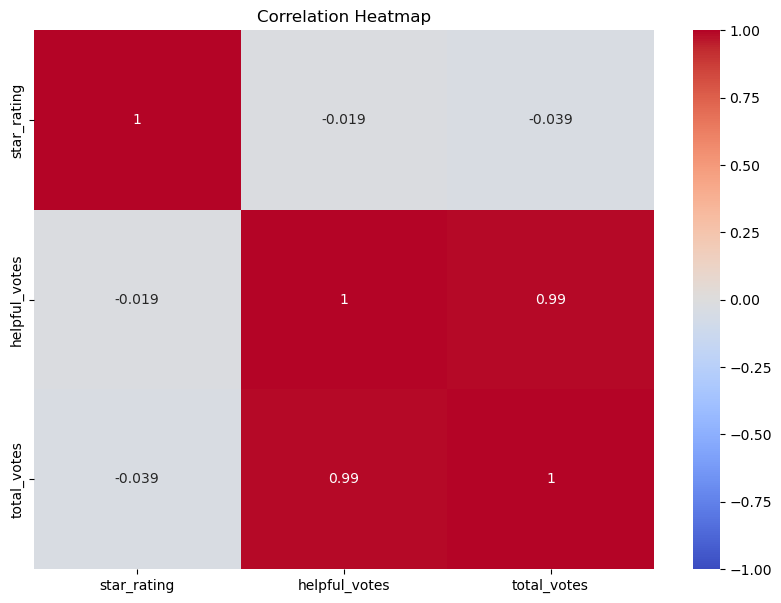

In [14]:
corr = df_pd[['star_rating', 'helpful_votes', 'total_votes']].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

### high correlation between helpful votes and total votes.

### Barplot of numerical variables

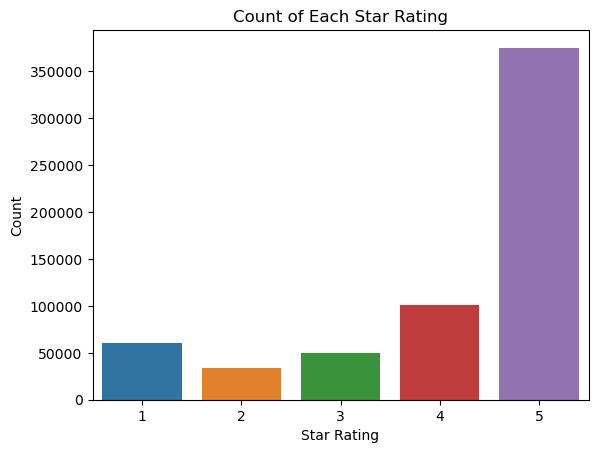

In [15]:
sns.countplot(x='star_rating', data=df_pd)
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Count of Each Star Rating')
plt.show()

In [16]:
df_pd.star_rating.value_counts()

5    375089
4    101247
1     59922
3     49310
2     33724
Name: star_rating, dtype: int64

In [17]:
df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619292 entries, 0 to 619291
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        619292 non-null  object
 1   customer_id        619292 non-null  int32 
 2   review_id          619292 non-null  object
 3   product_id         619292 non-null  object
 4   product_parent     619292 non-null  int32 
 5   product_title      619292 non-null  object
 6   product_category   619292 non-null  object
 7   star_rating        619292 non-null  int64 
 8   helpful_votes      619292 non-null  int32 
 9   total_votes        619292 non-null  int32 
 10  vine               619292 non-null  object
 11  verified_purchase  619292 non-null  object
 12  review_headline    619292 non-null  object
 13  review_body        619292 non-null  object
 14  review_date        619292 non-null  object
dtypes: int32(4), int64(1), object(10)
memory usage: 61.4+ MB


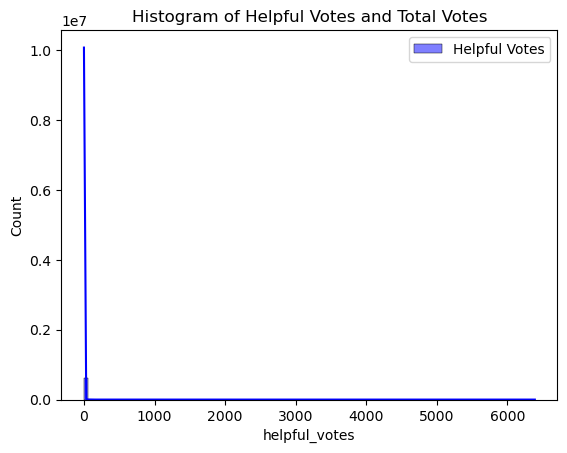

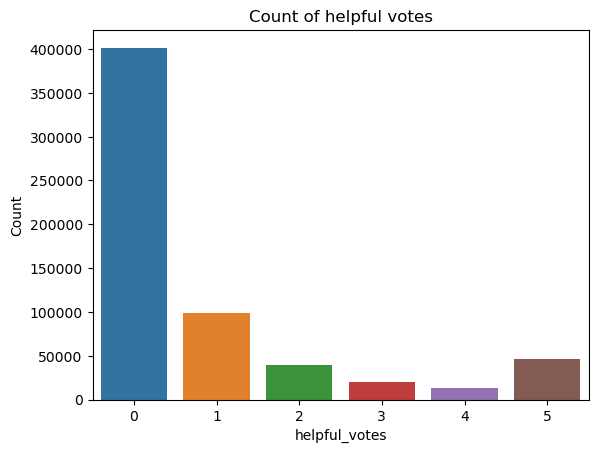

In [18]:
sns.histplot(df_pd['helpful_votes'], bins=100, kde=True, color='blue', label='Helpful Votes')
plt.title('Histogram of Helpful Votes and Total Votes')
plt.legend()
plt.show()


### after binning the data
df_pd['helpful_votes'] = df_pd['helpful_votes'].apply(lambda x: 5 if x > 5 else x)
sns.countplot(x='helpful_votes', data=df_pd)
plt.xlabel('helpful_votes')
plt.ylabel('Count')
plt.title('Count of helpful votes')
plt.show()

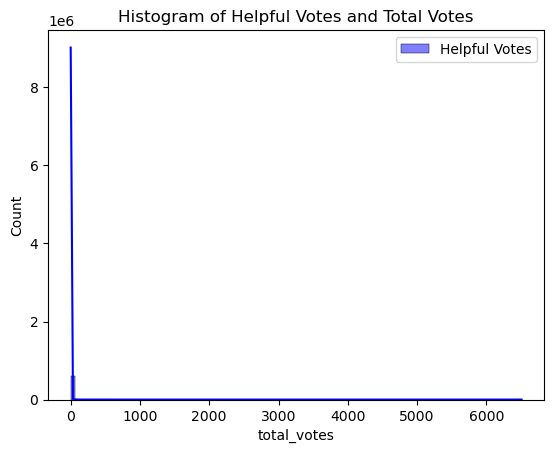

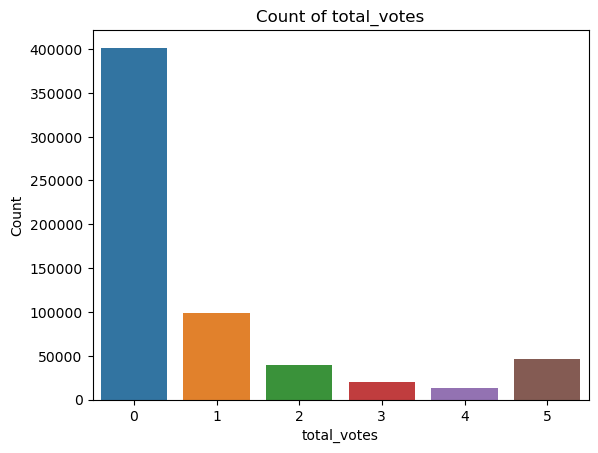

In [19]:
sns.histplot(df_pd['total_votes'], bins=100, kde=True, color='blue', label='Helpful Votes')
plt.title('Histogram of Helpful Votes and Total Votes')
plt.legend()
plt.show()


### after binning the data
df_pd['total_votes'] = df_pd['total_votes'].apply(lambda x: '>5' if x > 5 else str(x))
sns.countplot(x='helpful_votes', data=df_pd)
plt.xlabel('total_votes')
plt.ylabel('Count')
plt.title('Count of total_votes')
plt.show()

### Barplot of categorical variables

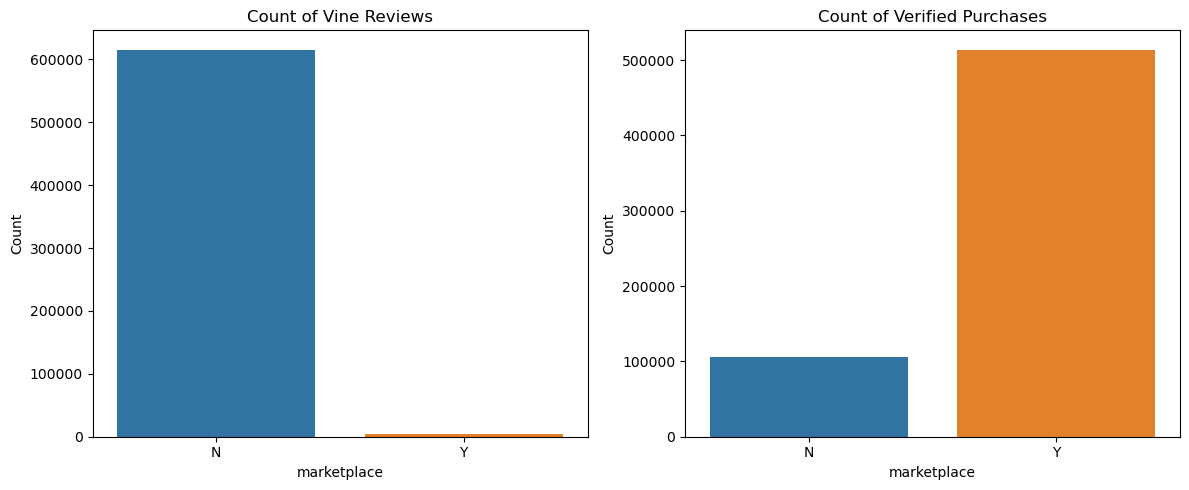

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# First plot for 'vine'
sns.countplot(x='vine', data=df_pd, ax=axes[0])
axes[0].set_xlabel('marketplace')
axes[0].set_ylabel('Count')
axes[0].set_title('Count of Vine Reviews')

# Second plot for 'verified_purchase'
sns.countplot(x='verified_purchase', data=df_pd, ax=axes[1])
axes[1].set_xlabel('marketplace')
axes[1].set_ylabel('Count')
axes[1].set_title('Count of Verified Purchases')

plt.tight_layout()  # Adjusts the plots so they don't overlap
plt.show()


### note: we may add a barplot of product_category later

vine
N   4
Y   4
Name: star_rating, dtype: float64
verified_purchase
N   4
Y   4
Name: star_rating, dtype: float64


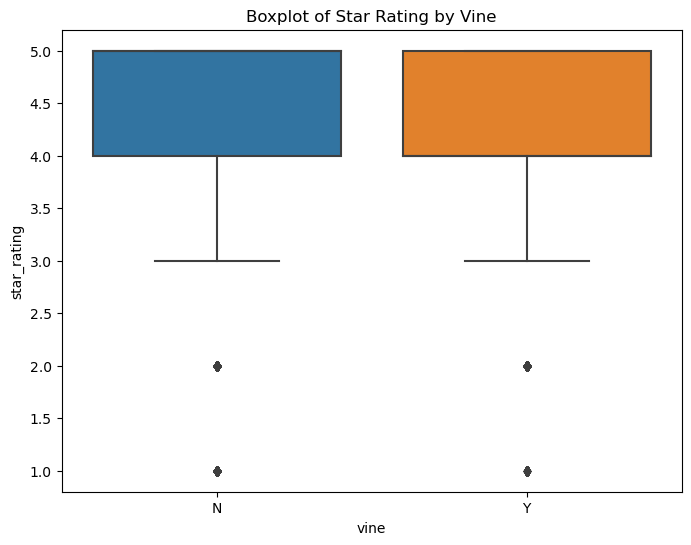

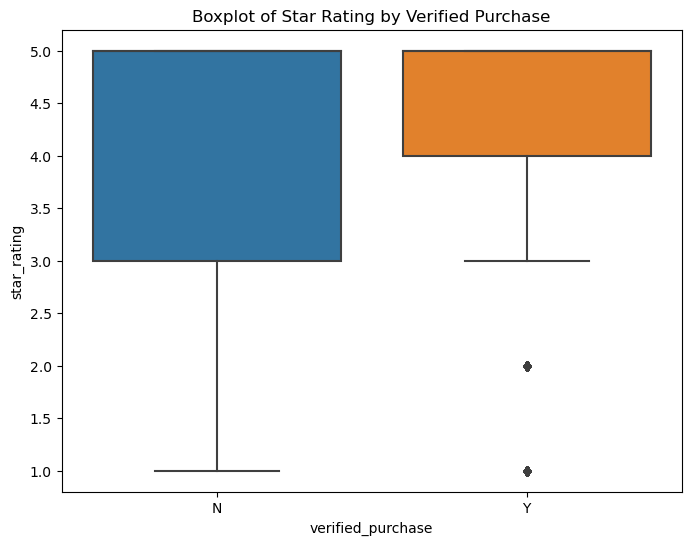

In [21]:
print(df_pd.groupby('vine')['star_rating'].mean())
print(df_pd.groupby('verified_purchase')['star_rating'].mean())



plt.figure(figsize=(8, 6))
sns.boxplot(x='vine', y='star_rating', data=df_pd)
plt.title('Boxplot of Star Rating by Vine')
plt.show()


plt.figure(figsize=(8, 6))
sns.boxplot(x='verified_purchase', y='star_rating', data=df_pd)
plt.title('Boxplot of Star Rating by Verified Purchase')
plt.show()

### Line plot of review_date

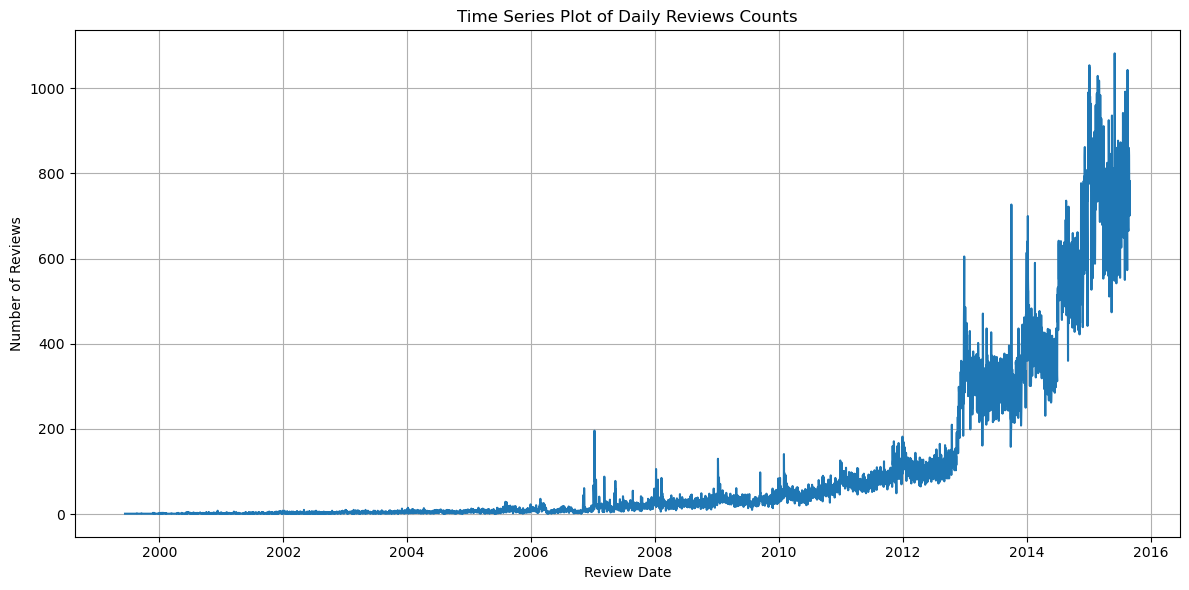

In [22]:

df_pd['review_date'] = pd.to_datetime(df_pd['review_date'])

daily_reviews_count = df_pd.groupby('review_date').size().reset_index(name='number_of_reviews')

plt.figure(figsize=(12, 6))
sns.lineplot(x='review_date', y='number_of_reviews', data=daily_reviews_count)
plt.title('Time Series Plot of Daily Reviews Counts')
plt.xlabel('Review Date')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.tight_layout()
plt.show()

### The graph depicts an sudden rise in review counts beginning in 2013, marking a distinct inflection point in the trend.

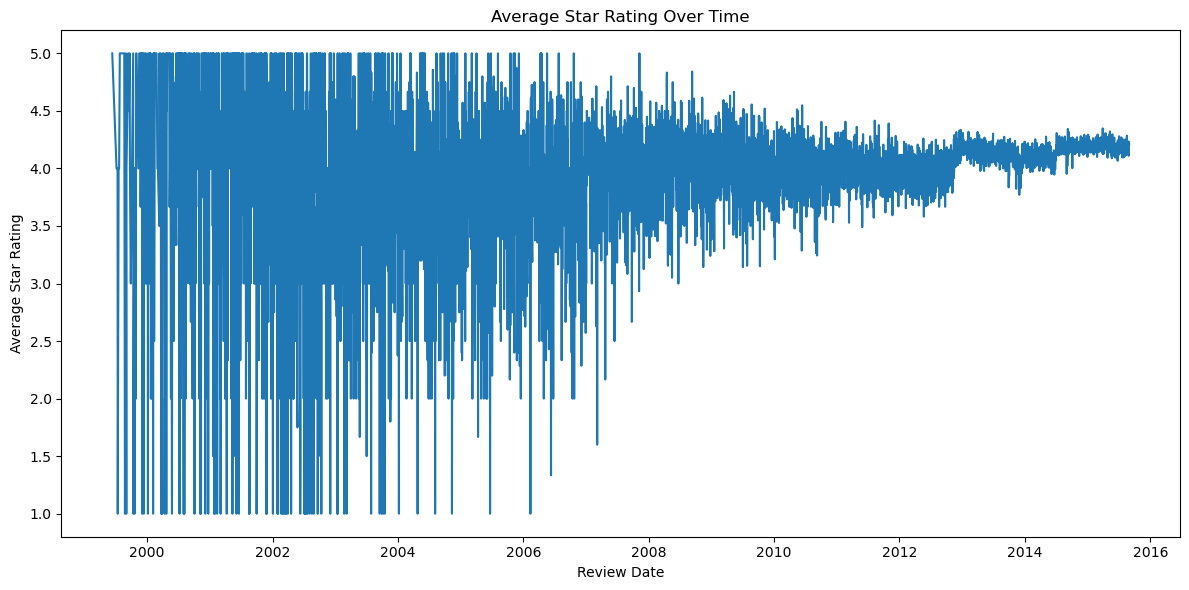

In [23]:
df_pd['review_date'] = pd.to_datetime(df_pd['review_date'])

avg_rating_per_date = df_pd.groupby('review_date')['star_rating'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(x='review_date', y='star_rating', data=avg_rating_per_date)
plt.title('Average Star Rating Over Time')
plt.ylabel('Average Star Rating')
plt.xlabel('Review Date')
plt.tight_layout()
plt.show()

### Initial Fluctuations (2000-2002): In the early years, around 2000 to 2002, there's a high variability in the ratings,
# with several peaks and valleys, indicating inconsistent feedback during this period.
# Stabilization (2003-now): From approximately 2003 to now, the average rating seems to stabilize around the 3.5 to 4.5 range,
# with less drastic fluctuations. This could indicate a period of consistent product or service quality, or perhaps more consistent expectations from reviewers.

In [24]:
pip install wordCloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.3/461.3 kB 9.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


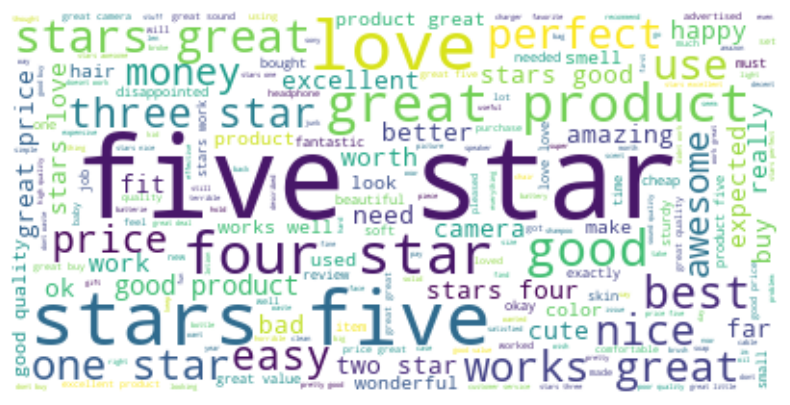

In [25]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = " ".join(review for review in df_pd.review_headline)
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Customer Segmentation

### Groupby customer_id and create a table

In [7]:
from pyspark.sql.functions import col as cl
df = data_text
df = df.withColumn('verified_purchase', when(cl('verified_purchase') == 'Y', 1).otherwise(0))
df = df.withColumn('vine', when(cl('vine') == 'Y', 1).otherwise(0))

In [8]:
df.createOrReplaceTempView("df")

sql1 = """
    select
        customer_id,
        count(distinct review_id) as review_nums,
        count(distinct product_id) as product_nums,
        avg(star_rating) as avg_star_rating,
        sum(helpful_votes) as sum_helpful_votes,
        sum(total_votes) as sum_total_votes,
        sum(case when vine = 1 then 1 else 0 end) as vine_Y_counts,
        sum(case when vine = 0 then 1 else 0 end) as vine_N_counts,
        sum(case when verified_purchase = 1 then 1 else 0 end) as verified_purchase_Y_counts,
        sum(case when verified_purchase = 0 then 1 else 0 end) as verified_purchase_N_counts
    from df
    group by customer_id
"""

result_df = spark.sql(sql1)
result_df.show(5)

+-----------+-----------+------------+------------------+-----------------+---------------+-------------+-------------+--------------------------+--------------------------+
|customer_id|review_nums|product_nums|   avg_star_rating|sum_helpful_votes|sum_total_votes|vine_Y_counts|vine_N_counts|verified_purchase_Y_counts|verified_purchase_N_counts|
+-----------+-----------+------------+------------------+-----------------+---------------+-------------+-------------+--------------------------+--------------------------+
|   20430792|          1|           1|               4.0|                0|              0|            0|            1|                         1|                         0|
|   35365573|          6|           6|3.1666666666666665|                5|              6|            0|            6|                         5|                         1|
|   25040030|          1|           1|               1.0|                1|              1|            0|            1|           

In [9]:
result_df.describe().show()

+-------+--------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+------------------+--------------------------+--------------------------+
|summary|         customer_id|       review_nums|      product_nums|   avg_star_rating|sum_helpful_votes|   sum_total_votes|       vine_Y_counts|     vine_N_counts|verified_purchase_Y_counts|verified_purchase_N_counts|
+-------+--------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+------------------+--------------------------+--------------------------+
|  count|             6261292|           6261292|           6261292|           6261292|          6261292|           6261292|             6261292|           6261292|                   6261292|                   6261292|
|   mean|2.6695039225957517E7|1.9824366919798662|1.9817111228800701| 4.033700751514602|3.906750076501783|  4.89611505101503|

### Find optimal K value 

23/11/27 21:43:23 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/11/27 21:43:24 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


With k=2, the Silhouette score is 0.9591479353945208


With k=3, the Silhouette score is 0.9269209881265005


With k=4, the Silhouette score is 0.9272180159394773


With k=5, the Silhouette score is 0.8634759871767272


With k=6, the Silhouette score is 0.14881074007784315


With k=7, the Silhouette score is 0.10462696549595425


With k=8, the Silhouette score is 0.28992073306776583


With k=9, the Silhouette score is 0.2814419164227345


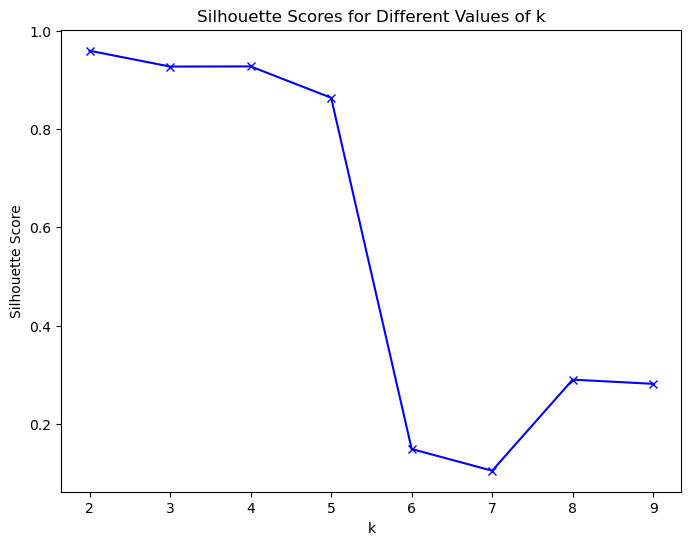

In [29]:
assembler = VectorAssembler(inputCols=['review_nums', 'product_nums', 'avg_star_rating', 'sum_helpful_votes', 'sum_total_votes', 
                                       'vine_Y_counts', 'vine_N_counts', 'verified_purchase_Y_counts', 'verified_purchase_N_counts'], outputCol='features')
vectorized_data = assembler.transform(result_df)

# Scale the features
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=False)
scaled_data = scaler.fit(vectorized_data).transform(vectorized_data)

k_values = range(2, 10)
silhouette_scores = []

for k in k_values:
    # Train the model
    kmeans = KMeans(featuresCol='scaledFeatures', k=k, seed=1)
    model = kmeans.fit(scaled_data)
    predictions = model.transform(scaled_data)
    
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    print(f"With k={k}, the Silhouette score is {silhouette}")

# Plot the silhouette scores to observe the elbow
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Values of k')
plt.show()


With k=2, the Silhouette score is 0.9593898553158717


With k=3, the Silhouette score is 0.9710190577779854


With k=4, the Silhouette score is 0.9295418320696341


With k=5, the Silhouette score is 0.1429899153002716


With k=6, the Silhouette score is 0.1768264389234364


With k=7, the Silhouette score is 0.575660819371534


With k=8, the Silhouette score is -0.04971032833766214


With k=9, the Silhouette score is 0.14899918627284608


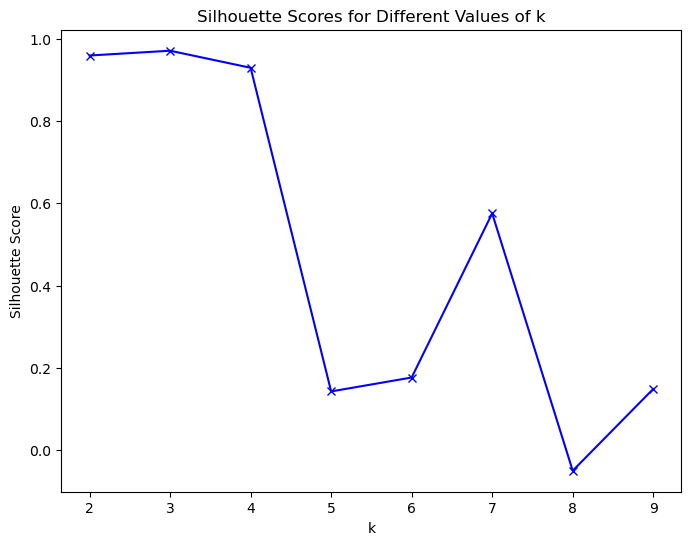

In [ ]:
assembler = VectorAssembler(inputCols=['review_nums', 'product_nums', 'avg_star_rating', 'sum_helpful_votes', 'sum_total_votes', 
                                       'vine_Y_counts', 'vine_N_counts', 'verified_purchase_Y_counts', 'verified_purchase_N_counts'], outputCol='features')
vectorized_data = assembler.transform(result_df)

# Scale the features
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=False)
scaled_data = scaler.fit(vectorized_data).transform(vectorized_data)

k_values = range(2, 10)
silhouette_scores = []

for k in k_values:
    # Train the model
    kmeans = KMeans(featuresCol='scaledFeatures', k=k, seed=1)
    model = kmeans.fit(scaled_data)
    predictions = model.transform(scaled_data)
    
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    print(f"With k={k}, the Silhouette score is {silhouette}")

# Plot the silhouette scores to observe the elbow
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Values of k')
plt.show()


### Build K-Means Model

In [10]:
### Optimal k: k = 4

In [14]:
assembler = VectorAssembler(inputCols=['review_nums', 'product_nums', 'avg_star_rating', 'sum_helpful_votes', 'sum_total_votes', 
                                       'vine_Y_counts', 'vine_N_counts', 'verified_purchase_Y_counts', 'verified_purchase_N_counts'], outputCol='features')
vectorized_data = assembler.transform(result_df)

# Scale the features
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=False)
scaled_data = scaler.fit(vectorized_data).transform(vectorized_data)

kmeans_final = KMeans(featuresCol='scaledFeatures', k=4, seed=1)
kmeans_final_model = kmeans_final.fit(scaled_data)
transformed_df = kmeans_final_model.transform(scaled_data)
transformed_df.show(5)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(transformed_df)
print(f"With k=4, the Silhouette score is {silhouette}")

transformed_df = transformed_df.withColumnRenamed('prediction', 'cluster')
transformed_df_pd = transformed_df.toPandas()
transformed_df_pd.cluster.value_counts()

+-----------+-----------+------------+-----------------+-----------------+---------------+-------------+-------------+--------------------------+--------------------------+--------------------+--------------------+----------+
|customer_id|review_nums|product_nums|  avg_star_rating|sum_helpful_votes|sum_total_votes|vine_Y_counts|vine_N_counts|verified_purchase_Y_counts|verified_purchase_N_counts|            features|      scaledFeatures|prediction|
+-----------+-----------+------------+-----------------+-----------------+---------------+-------------+-------------+--------------------------+--------------------------+--------------------+--------------------+----------+
|   47914293|          2|           2|              4.5|                1|              1|            0|            2|                         2|                         0|[2.0,2.0,4.5,1.0,...|[0.63369238900912...|         0|
|    9884235|          6|           6|4.166666666666667|                2|              2|      

With k=4, the Silhouette score is 0.12810486273063776


0    4682363
1    1429189
3     148525
2       1215
Name: cluster, dtype: int64

### Check statistics of each cluster and Set specific meaning to each customer cluster

In [ ]:
cluster_df = result_df
cluster_df = cluster_df.join(transformed_df.select("customer_id", "cluster"), "customer_id", "left")
cluster_df.show()

In [ ]:
###

cluster_df.createOrReplaceTempView("cluster_df")

sql1 = """
    select
        cluster,
        sum(review_nums) / count(distinct customer_id) as avg_review_nums,
        sum(product_nums) / count(distinct customer_id) as avg_product_nums,
        sum(avg_star_rating) / count(distinct customer_id) as avg_star_rating,
        sum(sum_helpful_votes) / count(distinct customer_id) as avg_helpful_votes,
        sum(sum_helpful_votes) / count(distinct customer_id) as avg_total_votes,
        sum(vine_Y_counts) / count(distinct customer_id)as avg_vine_Y_counts,
        sum(vine_N_counts) / count(distinct customer_id) as avg_vine_N_counts,
        sum(verified_purchase_Y_counts) / count(distinct customer_id) as avg_verified_purchase_Y_counts,
        sum(verified_purchase_N_counts) / count(distinct customer_id) as avg_verified_purchase_N_counts
    from cluster_df
    group by 
        cluster
"""

cluster_stat = spark.sql(sql1)
cluster_stat.show()

In [ ]:
define a new variable: product review engagement
    
0/1: low engagement
3: middle engagement
2: high engagement

### Business strategy suggestion

In [ ]:
low engagement
Increase Engagement: Implement targeted marketing strategies to increase customer engagement, such as email campaigns that encourage reviews in exchange for a discount on future purchases.
Feedback Loop: Send out surveys or feedback requests to understand why their engagement is low and what could be improved in their experience.
    
middle engagement
Loyalty Programs: Offer a loyalty program that rewards customers for their reviews and purchases, encouraging them to continue engaging and potentially increase their activity level.
Community Building: Invite these customers to a VIP club or community where they can share their experiences, get early access to new products, and feel more connected to the brand.
    
high engagement
Exclusive Access: Provide early access to new products, special editions, or exclusive previews as a reward for their high engagement.
Co-creation Opportunities: Engage them in product development processes through beta testing or feedback sessions to leverage their engagement in improving product offerings.